In [57]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import KNNBasic
import gzip

# Load & Sample data

In [58]:
dt = pd.read_csv('ratings_Grocery_and_Gourmet_Food.csv')

In [59]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297155 entries, 0 to 1297154
Data columns (total 4 columns):
A1ZQZ8RJS1XVTX    1297155 non-null object
0657745316        1297155 non-null object
5.0               1297155 non-null float64
1381449600        1297155 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 39.6+ MB


In [60]:
dt.columns = ['reviewerID','productID','rating','unixTime']

In [61]:
dt.head()

reviewerID   productID  rating    unixTime
0  A31W38VGZAUUM4  0700026444     5.0  1354752000
1  A3I0AV0UJX5OH0  1403796890     1.0  1385942400
2  A3QAAOLIXKV383  1403796890     3.0  1307836800
3   AB1A5EGHHVA9M  141278509X     5.0  1332547200
4  A3DTB6RVENLQ9Q  1453060375     1.0  1362268800

In [62]:
dt['unixTime'] = pd.to_datetime(dt['unixTime'],unit='s')
dt = dt.rename(columns={'unixTime':'date'})

In [63]:
#Only take recent reviews
dt = dt.loc[dt['date']>'2011-01-01']
#Last Date
dt['date'].max()

Timestamp('2014-07-23 00:00:00')

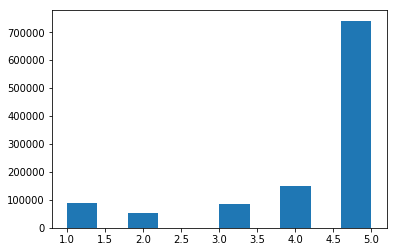

In [64]:
#Histogram of ratings
rating_hist = plt.hist(dt['rating'],align='mid')

In [65]:
#Group new data by product
user_groupby = dt.groupby('reviewerID',as_index=False)
user_review_count = user_groupby['productID'].count()
user_review_count.columns = ['reviewerID','count_review']

In [66]:
#Take top users who rated the most
user_most_ratings = user_review_count.sort_values(by='count_review',ascending=False).head(50)

In [67]:
#Find products rated by these top users
product_rated = dt.loc[dt['reviewerID'].isin(user_most_ratings['reviewerID'])]

In [68]:
#Take top products among top users (i.e top products most rated by top users)
product_to_sample = product_rated.pivot_table('rating',index='productID',aggfunc=len).sort_values(by='rating',ascending=False).head(100)

In [69]:
#Filter original data for these products only
data = dt.loc[dt['productID'].isin(product_to_sample.index)]

In [70]:
#Drop users who have few ratings
ureview_count = data.pivot_table('rating',index='reviewerID',aggfunc=len)
user_interest = ureview_count[ureview_count['rating']>=4]
data = data.loc[data['reviewerID'].isin(user_interest.index)] 

In [71]:
#data.to_csv('sample_data.csv')

In [72]:
data.describe()

rating
count  9989.000000
mean      3.840625
std       1.083991
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000

In [73]:
data['reviewerID'].nunique()

1050

In [74]:
len(data)/(data['reviewerID'].nunique()*data['productID'].nunique())

0.09513333333333333

# Import metadata of products

In [ ]:
# Read meta data of products into data frame
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df_meta = getDF('meta_Grocery_and_Gourmet_Food.json.gz')

In [ ]:
df_meta.rename(columns={'asin':'productID'},inplace='True')
df_meta.head()

In [ ]:
# Acquire list of products to filter from all products
product_list = list(set(data['productID']))
df_meta = df_meta.loc[df_meta['productID'].isin(product_list)]

In [ ]:
#df_meta.to_csv('sample_data_meta.csv')